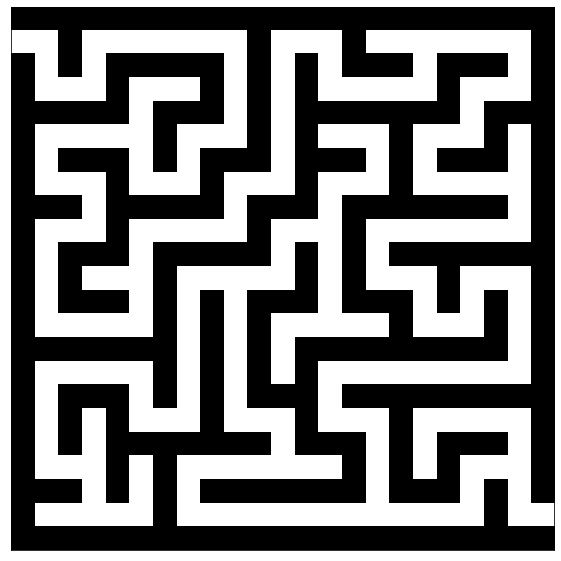

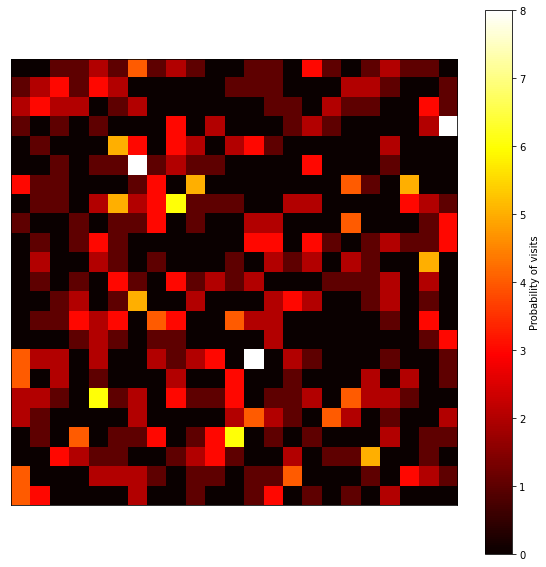

In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate

class Maze:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = np.ones((height, width), dtype=int)  # Walls are 1, paths are 0
        self.generate_maze()

    def generate_maze(self):
        self._recursive_backtracker(1, 1)
        self.grid[1, 0] = 0  # Entry
        self.grid[self.height - 2, self.width - 1] = 0  # Exit

    def _recursive_backtracker(self, x, y):
        self.grid[y, x] = 0  # Mark the current cell as a path
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx * 2, y + dy * 2
            if 1 <= nx < self.width - 1 and 1 <= ny < self.height - 1 and self.grid[ny, nx] == 1:
                self.grid[ny - dy, nx - dx] = 0  # Knock down the wall
                self._recursive_backtracker(nx, ny)

    def display(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.grid, cmap='binary')
        plt.xticks([]), plt.yticks([])
        plt.show()

class QuantumWalk2D:
    def __init__(self, maze):
        self.maze = maze
        self.simulator = AerSimulator()

    def create_quantum_walk_circuit(self, steps):
        num_qubits = int(np.ceil(np.log2(self.maze.width * self.maze.height)))
        qc = QuantumCircuit(num_qubits, num_qubits)

        # Apply Hadamard gate to create superposition
        for qubit in range(num_qubits):
            qc.h(qubit)

        # Define the step operator
        step_operator = self.create_step_operator(num_qubits)
        step_gate = UnitaryGate(step_operator, label='Step')

        for _ in range(steps):
            qc.append(step_gate, range(num_qubits))

        # Measure the qubits
        qc.measure(range(num_qubits), range(num_qubits))

        return qc

    def create_step_operator(self, num_qubits):
        size = 2 ** num_qubits
        operator = np.zeros((size, size), dtype=complex)

        # Define valid transitions based on the maze
        for y in range(self.maze.height):
            for x in range(self.maze.width):
                if self.maze.grid[y, x] == 0:
                    current_pos = x + y * self.maze.width
                    neighbors = self.get_neighbors(x, y)
                    for neighbor in neighbors:
                        neighbor_pos = neighbor[0] + neighbor[1] * self.maze.width
                        operator[neighbor_pos, current_pos] = 1 / np.sqrt(len(neighbors))

        # Normalize and ensure unitarity
        operator = np.array(operator, dtype=complex)
        u, s, vh = np.linalg.svd(operator)
        operator = np.dot(u, vh)

        return operator

    def get_neighbors(self, x, y):
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze.width and 0 <= ny < self.maze.height and self.maze.grid[ny, nx] == 0:
                neighbors.append((nx, ny))
        return neighbors
    
    def solve_maze(self, steps):
        qc = self.create_quantum_walk_circuit(steps)
        compiled_circuit = transpile(qc, self.simulator)
        result = self.simulator.run(compiled_circuit).result()
        counts = result.get_counts(qc)
        self.display_counts(counts)

    def display_counts(self, counts):
        probabilities = np.zeros((self.maze.height, self.maze.width))
        for state, count in counts.items():
            index = int(state, 2)
            x = index % self.maze.width
            y = index // self.maze.width
            if 0 <= x < self.maze.width and 0 <= y < self.maze.height:
                probabilities[y, x] += count

        plt.figure(figsize=(10, 10))
        plt.imshow(probabilities, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Probability of visits')
        plt.xticks([]), plt.yticks([])
        plt.show()


# Create a maze and a quantum walk instance
maze = Maze(23, 23)
maze.display()

quantum_walk = QuantumWalk2D(maze)
solved = quantum_walk.solve_maze(steps=10)  # Adjust the number of steps for the quantum walk


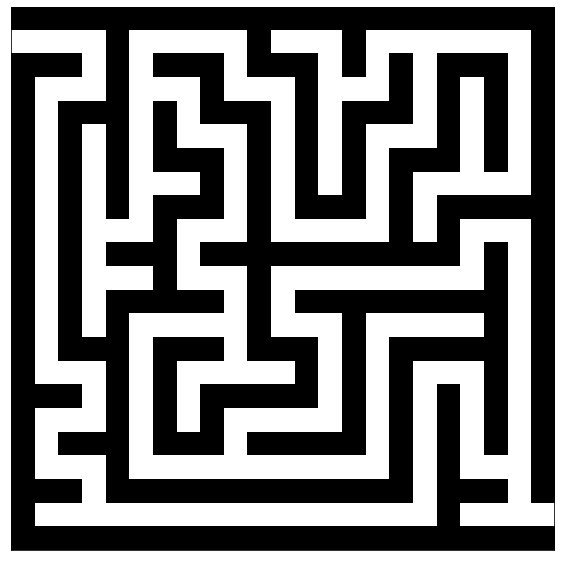

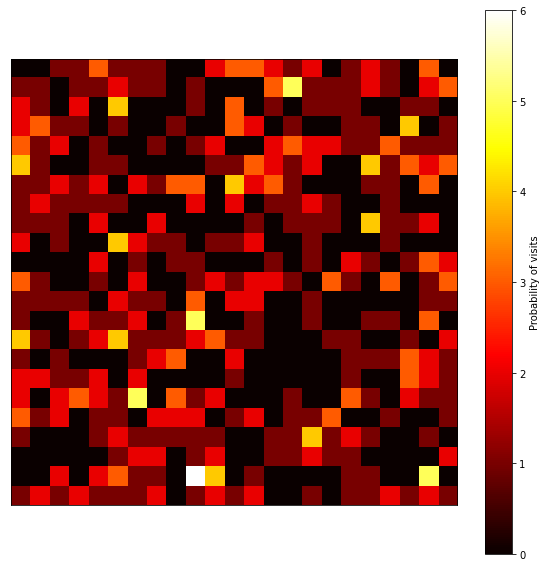

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate

class Maze:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = np.ones((height, width), dtype=int)  # Walls are 1, paths are 0
        self.generate_maze()

    def generate_maze(self):
        self._recursive_backtracker(1, 1)
        self.grid[1, 0] = 0  # Entry
        self.grid[self.height - 2, self.width - 1] = 0  # Exit

    def _recursive_backtracker(self, x, y):
        self.grid[y, x] = 0  # Mark the current cell as a path
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx * 2, y + dy * 2
            if 1 <= nx < self.width - 1 and 1 <= ny < self.height - 1 and self.grid[ny, nx] == 1:
                self.grid[ny - dy, nx - dx] = 0  # Knock down the wall
                self._recursive_backtracker(nx, ny)

    def display(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.grid, cmap='binary')
        plt.xticks([]), plt.yticks([])
        plt.show()

class QuantumWalk2D:
    def __init__(self, maze):
        self.maze = maze
        self.simulator = AerSimulator()
        self.num_qubits = int(np.ceil(np.log2(self.maze.width * self.maze.height)))

    def create_quantum_walk_circuit(self, steps):
        qc = QuantumCircuit(self.num_qubits, self.num_qubits)

        # Apply Hadamard gate to create superposition
        for qubit in range(self.num_qubits):
            qc.h(qubit)

        # Define the step operator
        step_operator = self.create_step_operator()
        step_gate = UnitaryGate(step_operator, label='Step')

        for _ in range(steps):
            qc.append(step_gate, range(self.num_qubits))

        # Measure the qubits
        qc.measure(range(self.num_qubits), range(self.num_qubits))

        return qc

    def create_step_operator(self):
        size = 2 ** self.num_qubits
        operator = np.eye(size, dtype=complex)

        # Define valid transitions based on the maze
        for y in range(self.maze.height):
            for x in range(self.maze.width):
                if self.maze.grid[y, x] == 0:
                    current_pos = x + y * self.maze.width
                    neighbors = self.get_neighbors(x, y)
                    if neighbors:
                        for neighbor in neighbors:
                            neighbor_pos = neighbor[0] + neighbor[1] * self.maze.width
                            operator[neighbor_pos, current_pos] = 1 / np.sqrt(len(neighbors))

        # Normalize and ensure unitarity
        operator = np.array(operator, dtype=complex)
        u, s, vh = np.linalg.svd(operator)
        operator = np.dot(u, vh)

        return operator

    def get_neighbors(self, x, y):
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze.width and 0 <= ny < self.maze.height and self.maze.grid[ny, nx] == 0:
                neighbors.append((nx, ny))
        return neighbors

    def solve_maze(self, steps):
        qc = self.create_quantum_walk_circuit(steps)
        compiled_circuit = transpile(qc, self.simulator)
        result = self.simulator.run(compiled_circuit).result()
        counts = result.get_counts(qc)
        self.display_counts(counts)

    def display_counts(self, counts):
        probabilities = np.zeros((self.maze.height, self.maze.width))
        for state, count in counts.items():
            index = int(state, 2)
            x = index % self.maze.width
            y = index // self.maze.width
            if 0 <= x < self.maze.width and 0 <= y < self.maze.height:
                probabilities[y, x] += count

        plt.figure(figsize=(10, 10))
        plt.imshow(probabilities, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Probability of visits')
        plt.xticks([]), plt.yticks([])
        plt.show()

# Create a maze and a quantum walk instance
maze = Maze(23, 23)
maze.display()

quantum_walk = QuantumWalk2D(maze)
quantum_walk.solve_maze(steps=1)  # Adjust the number of steps for the quantum walk

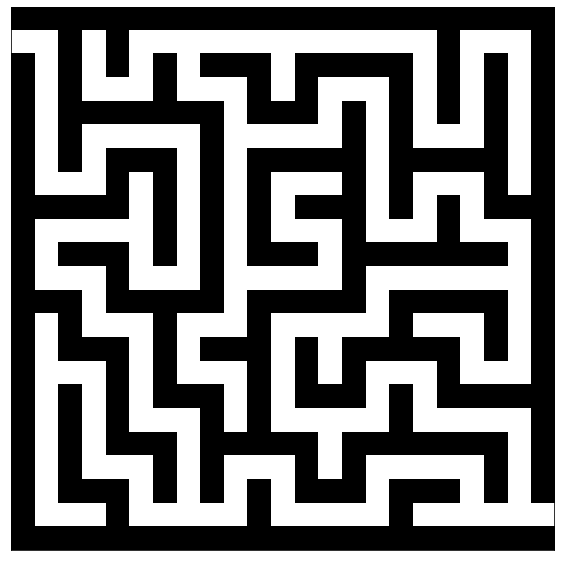

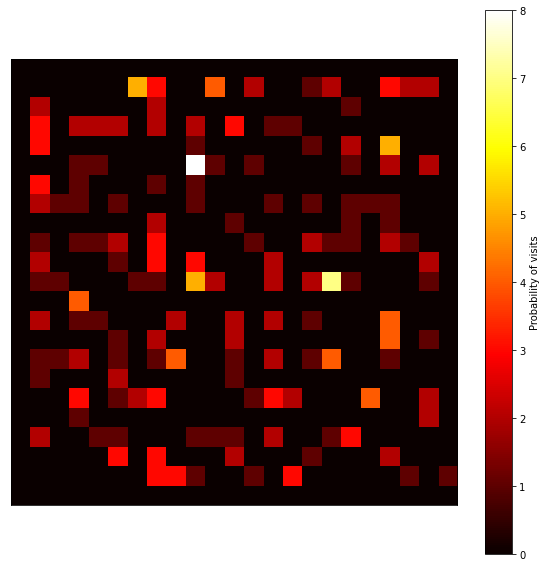

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate

class Maze:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = np.ones((height, width), dtype=int)  # Walls are 1, paths are 0
        self.generate_maze()

    def generate_maze(self):
        self._recursive_backtracker(1, 1)
        self.grid[1, 0] = 0  # Entry
        self.grid[self.height - 2, self.width - 1] = 0  # Exit

    def _recursive_backtracker(self, x, y):
        self.grid[y, x] = 0  # Mark the current cell as a path
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx * 2, y + dy * 2
            if 1 <= nx < self.width - 1 and 1 <= ny < self.height - 1 and self.grid[ny, nx] == 1:
                self.grid[ny - dy, nx - dx] = 0  # Knock down the wall
                self._recursive_backtracker(nx, ny)

    def display(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.grid, cmap='binary')
        plt.xticks([]), plt.yticks([])
        plt.show()

class QuantumWalk2D:
    def __init__(self, maze):
        self.maze = maze
        self.simulator = AerSimulator()
        self.num_qubits = int(np.ceil(np.log2(self.maze.width * self.maze.height)))

    def create_quantum_walk_circuit(self, steps):
        qc = QuantumCircuit(self.num_qubits, self.num_qubits)

        # Apply Hadamard gate to create superposition
        for qubit in range(self.num_qubits):
            qc.h(qubit)

        # Define the step operator
        step_operator = self.create_step_operator()
        step_gate = UnitaryGate(step_operator, label='Step')

        for _ in range(steps):
            qc.append(step_gate, range(self.num_qubits))

        # Measure the qubits
        qc.measure(range(self.num_qubits), range(self.num_qubits))

        return qc

    def create_step_operator(self):
        size = 2 ** self.num_qubits
        operator = np.zeros((size, size), dtype=complex)

        # Define valid transitions based on the maze
        for y in range(self.maze.height):
            for x in range(self.maze.width):
                if self.maze.grid[y, x] == 0:
                    current_pos = x + y * self.maze.width
                    neighbors = self.get_neighbors(x, y)
                    if neighbors:
                        for neighbor in neighbors:
                            neighbor_pos = neighbor[0] + neighbor[1] * self.maze.width
                            operator[neighbor_pos, current_pos] = 1 / np.sqrt(len(neighbors))

        # Normalize and ensure unitarity
        operator = np.array(operator, dtype=complex)
        u, s, vh = np.linalg.svd(operator)
        operator = np.dot(u, vh)

        return operator

    def get_neighbors(self, x, y):
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze.width and 0 <= ny < self.maze.height and self.maze.grid[ny, nx] == 0:
                neighbors.append((nx, ny))
        return neighbors

    def solve_maze(self, steps):
        qc = self.create_quantum_walk_circuit(steps)
        compiled_circuit = transpile(qc, self.simulator)
        result = self.simulator.run(compiled_circuit).result()
        counts = result.get_counts(qc)
        self.display_counts(counts)

    def display_counts(self, counts):
        probabilities = np.zeros((self.maze.height, self.maze.width))
        for state, count in counts.items():
            index = int(state, 2)
            x = index % self.maze.width
            y = index // self.maze.width
            if 0 <= x < self.maze.width and 0 <= y < self.maze.height and self.maze.grid[y, x] == 0:
                probabilities[y, x] += count

        plt.figure(figsize=(10, 10))
        plt.imshow(probabilities, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Probability of visits')
        plt.xticks([]), plt.yticks([])
        plt.show()

# Create a maze and a quantum walk instance
maze = Maze(23, 23)
maze.display()

quantum_walk = QuantumWalk2D(maze)
quantum_walk.solve_maze(steps=25)  # Adjust the number of steps for the quantum walk
